# Lupus Cohort

This is a cohort of individuals with Lupus. I pulled this dataset because it contains a group of patients with sorted (purified cell populations) blood samples profiled across multiple different cell types. 

In [1]:
import os 
if os.getcwd().endswith('Other'):
    os.chdir('..')

In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [3]:
from Setup.MethylationAgeModels import *

importing IPython notebook from Setup/MethylationAgeModels

In [5]:
GSE65097_MATRIX = './data/GSE65097_series_matrix.txt.gz'
GSE65097_MATRIX = os.path.abspath(GSE65097_MATRIX)
URL = ('ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE65nnn/GSE65097/'
       'matrix/GSE65097_series_matrix.txt.gz')
if not os.path.isfile(GSE65097_MATRIX):
    !curl $URL -o $GSE65097_MATRIX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.5M  100 75.5M    0     0  6856k      0  0:00:11  0:00:11 --:--:-- 12.8M


In [7]:
ann = pd.read_table(GSE65097_MATRIX, skiprows=28, nrows=38, index_col=0)

In [8]:
a2 = ann.ix['!Sample_characteristics_ch1']

In [33]:
cell_type = a2.ix[3].map(lambda s: s.split(': ')[1].split()[1])
cell_type.value_counts()

neutrophils    30
low-density     8
dtype: int64

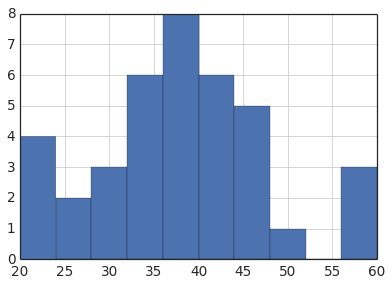

In [45]:
age = a2.ix[0].map(lambda s: s.split(': ')[1]).astype(float)
age.name = 'age'
age.hist()

In [12]:
disease = a2.ix[2].map(lambda s: s.split(': ')[1])
disease.value_counts()

Lupus patient    21
control          17
dtype: int64

In [21]:
patient = pd.Series({i: i.split()[-1] for i in cell_type.index})
patient.value_counts().value_counts()

3    8
2    7
dtype: int64

In [28]:
data = pd.read_table(GSE65097_MATRIX, skiprows=68, index_col=0,
                     header=None, names=a2.columns,
                     na_values=['null'])
#data = data.dropna()
data = data.fillna(data.mean(1))
gs = pd.read_csv('./data/Hannum_gold_standard.csv', header=None, 
                 index_col=0, squeeze=True)
data = data.T.fillna(gs).T
data = data.ix[:, ti(cell_type == 'neutrophils')]

In [35]:
h1 = run_horvath_model(data)
h2 = run_hannum_model(data)

In [37]:
diff = ((h1 - h2) / ((h1 + h2) * .5)).abs()
k = ti(diff < .5)

In [38]:
combined = (h1 + h2) / 2
combined = combined

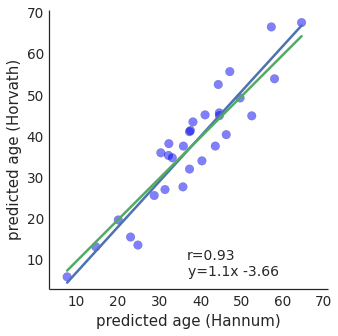

In [41]:
hannum_adj = detrend(age, h2).dropna()
horvath_adj = detrend(age, h1).dropna()
pred_c = (hannum_adj + horvath_adj) / 2
diff = ((hannum_adj - horvath_adj) / ((hannum_adj + horvath_adj) * .5)).abs()
k = ti(diff < .3)
pred_c = detrend(age.ix[k].dropna(), pred_c)
#aa['pred'] = pred_c
plot_regression(hannum_adj, horvath_adj)

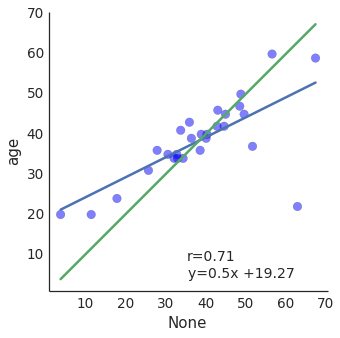

In [52]:
plot_regression(pred_c, age)

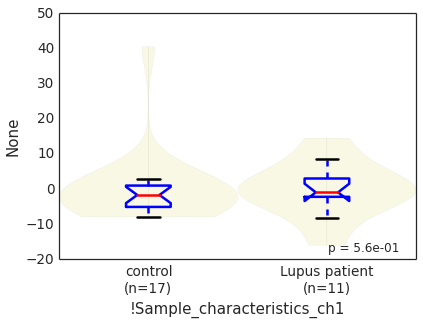

In [53]:
violin_plot_pandas(disease, pred_c - age)

In [54]:
pt = ti((pred_c - age) < 30)

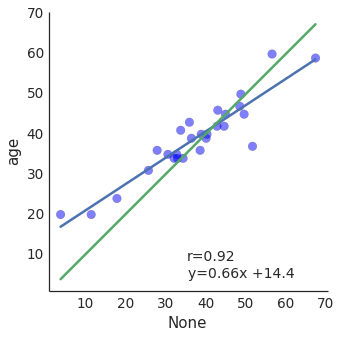

In [55]:
plot_regression(pred_c.ix[pt], age)

In [57]:
m_vals = logit_adj(data)

In [62]:
age_corr_t = m_vals.T.ix[pt].corrwith(age.ix[pt].astype(float))

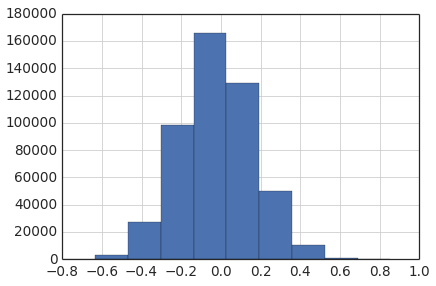

In [63]:
age_corr_t.hist()

In [64]:
age_corr_t.to_csv('/cellar/users/agross/Data/Methylation_Controls/neutrophils_age_corr.csv')